In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [5]:
drug_sales = pd.read_csv('PharmaDrugSales_1.csv')

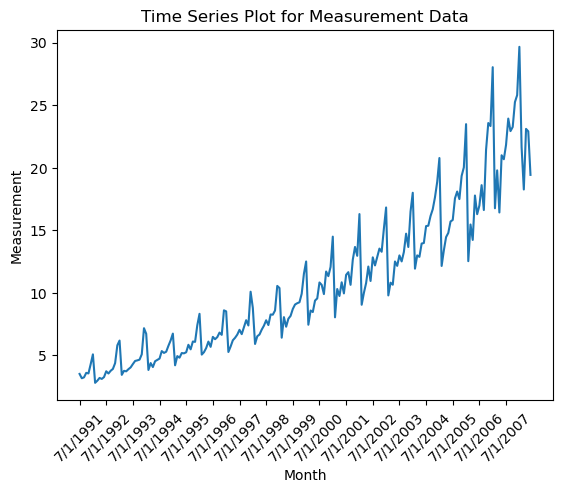

In [6]:
plt.plot(drug_sales['Month'], drug_sales['Sales'])
plt.title('Time Series Plot for Measurement Data')
plt.xlabel('Month')
plt.ylabel('Measurement')
plt.xticks(drug_sales['Month'][::12], rotation=45)
plt.show()

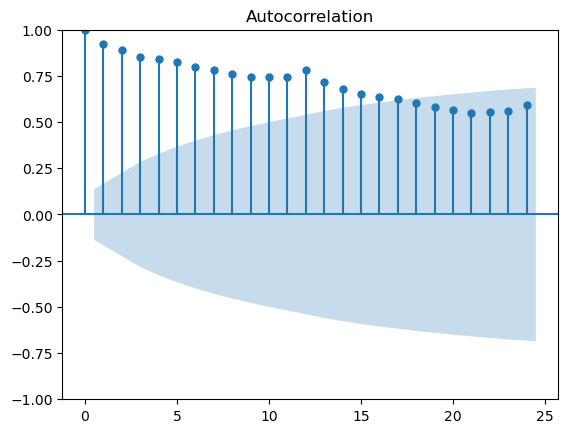

In [7]:
acf_plot = plot_acf(drug_sales['Sales'])

#Seasonal period is 12 months or 1 year

In [8]:
drug_sales['Moving_Avg'] = drug_sales['Sales'].rolling(window=12).mean()
print(drug_sales)

         Month      Sales  Moving_Avg
0     7/1/1991   3.526591         NaN
1     8/1/1991   3.180891         NaN
2     9/1/1991   3.252221         NaN
3    10/1/1991   3.611003         NaN
4    11/1/1991   3.565869         NaN
..         ...        ...         ...
199   2/1/2008  21.654285   22.686363
200   3/1/2008  18.264945   22.559045
201   4/1/2008  23.107677   23.115743
202   5/1/2008  22.912510   23.275057
203   6/1/2008  19.431740   23.170952

[204 rows x 3 columns]


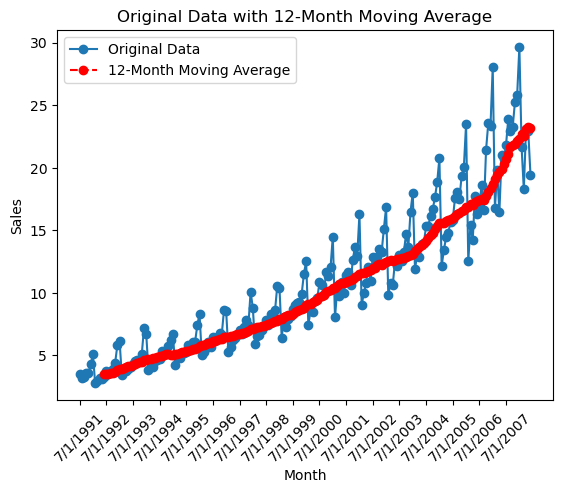

In [9]:
plt.plot(drug_sales['Month'], drug_sales['Sales'], label='Original Data', marker='o')
plt.plot(drug_sales['Month'], drug_sales['Moving_Avg'], label='12-Month Moving Average',
         linestyle='--', color='red', marker='o')
plt.legend()
plt.title("Original Data with 12-Month Moving Average")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(drug_sales['Month'][::12], rotation=45)
plt.show()


In [10]:
drug_sales['Measurement First Difference'] = drug_sales['Sales'] - drug_sales['Sales'].shift(1)
print(drug_sales.head())
drug_diff = drug_sales['Measurement First Difference'].dropna()

#The trend is increasing.

       Month     Sales  Moving_Avg  Measurement First Difference
0   7/1/1991  3.526591         NaN                           NaN
1   8/1/1991  3.180891         NaN                     -0.345700
2   9/1/1991  3.252221         NaN                      0.071330
3  10/1/1991  3.611003         NaN                      0.358782
4  11/1/1991  3.565869         NaN                     -0.045134


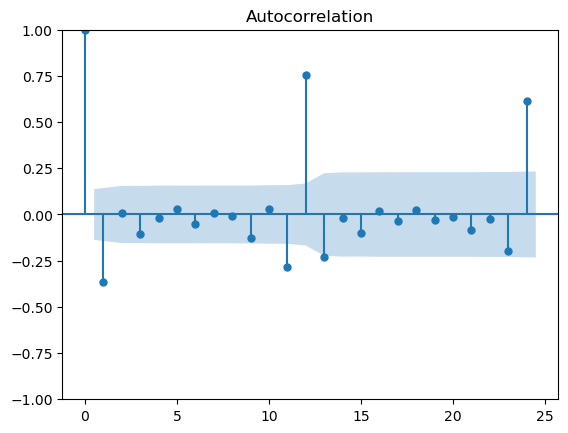

In [11]:
#ACF
acf_plot = plot_acf(drug_diff)

/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


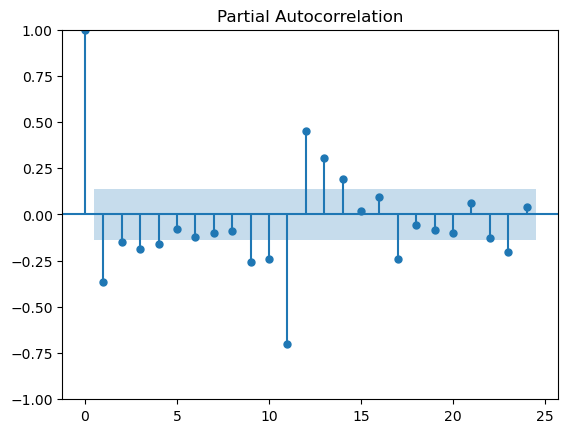

In [12]:
#PACF
acf_plot = plot_pacf(drug_diff)


5(b). Comparing both ACF plots we see that after the first differencing of time-series the TREND has been removed.

In [13]:
drug_sales['seasonal_difference'] = drug_sales['Sales'].diff(periods=12)
drug_seasonal_diff = drug_sales['seasonal_difference'].dropna()
print(drug_sales.head(13))

        Month     Sales  Moving_Avg  Measurement First Difference  \
0    7/1/1991  3.526591         NaN                           NaN   
1    8/1/1991  3.180891         NaN                     -0.345700   
2    9/1/1991  3.252221         NaN                      0.071330   
3   10/1/1991  3.611003         NaN                      0.358782   
4   11/1/1991  3.565869         NaN                     -0.045134   
5   12/1/1991  4.306371         NaN                      0.740502   
6    1/1/1992  5.088335         NaN                      0.781964   
7    2/1/1992  2.814520         NaN                     -2.273815   
8    3/1/1992  2.985811         NaN                      0.171291   
9    4/1/1992  3.204780         NaN                      0.218969   
10   5/1/1992  3.127578         NaN                     -0.077202   
11   6/1/1992  3.270523    3.494541                      0.142945   
12   7/1/1992  3.737851    3.512146                      0.467328   

    seasonal_difference  
0      

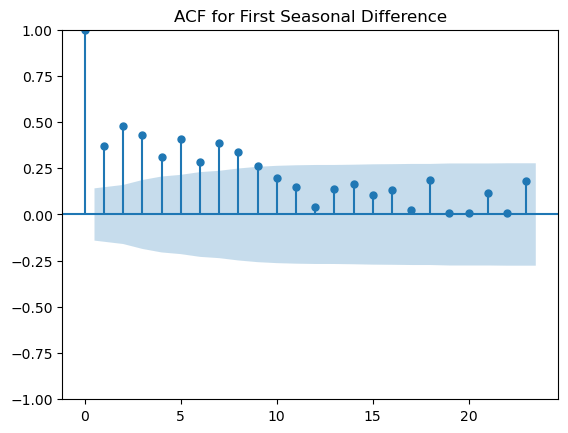

In [14]:
#ACF
plot_acf(drug_seasonal_diff)
plt.title('ACF for First Seasonal Difference')
plt.show()

/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


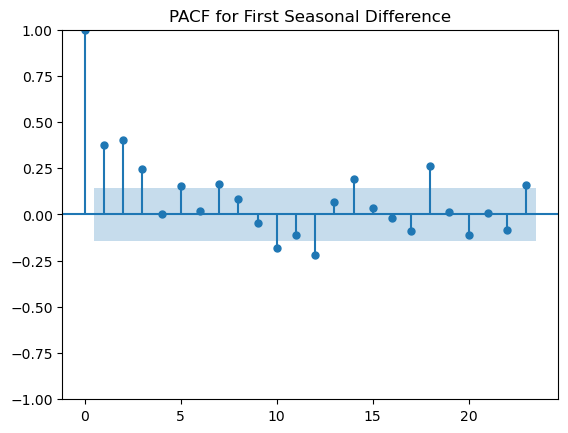

In [15]:
#PACF
plot_pacf(drug_seasonal_diff)
plt.title('PACF for First Seasonal Difference')
plt.show()

<Axes: >

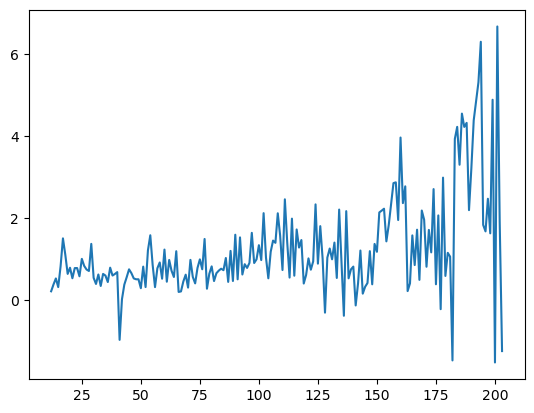

In [16]:
# Seasonality is removed after first seasonal difference

drug_seasonal_diff.plot()

In [17]:
drug_sales['Month'] = pd.to_datetime(drug_sales['Month'])
print(drug_sales['Month'])

0     1991-07-01
1     1991-08-01
2     1991-09-01
3     1991-10-01
4     1991-11-01
         ...    
199   2008-02-01
200   2008-03-01
201   2008-04-01
202   2008-05-01
203   2008-06-01
Name: Month, Length: 204, dtype: datetime64[ns]


In [34]:
train = drug_sales[drug_sales['Month'] <= '2005-06-01']

# function to get the best SARIMA parameters

def sarima(data, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_results = None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, s)
                            try:
                                model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
                                results = model.fit(disp=0)
                                aic = results.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                                    best_results = results
                            except Exception as e:
                                print(
                                    f"Error with parameters: {order}x{seasonal_order} - {e}")
                                continue

    return best_order, best_seasonal_order, best_aic, best_results



# range for each parameter
p_values = range(4)
d_values = [1]
q_values = range(4)
P_values = range(4)
D_values = [1]
Q_values = range(4)
s = 12

best_order, best_seasonal_order, best_aic, best_results = sarima(train['Sales'], p_values, d_values, q_values, P_values, D_values, Q_values, s)

print("AIC:", best_aic)
print("SARIMA Configuration: ", best_order, "-", best_seasonal_order)


/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/neharana/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/neharana/anaconda3/lib/python3.11/site-packag

AIC: 270.95109565998956
SARIMA Configuration:  (3, 1, 1) - (1, 1, 3, 12)


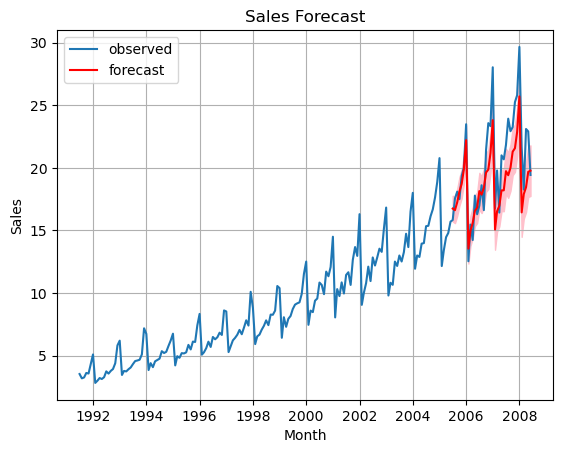

In [37]:
test = drug_sales[drug_sales['Month'] > '2005-06-01']

# Forecast the sales for the test data duration
forecast = best_results.get_forecast(steps=len(test))
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the past sales data, the forecast, and the confidence intervals
plt.plot(drug_sales['Month'], drug_sales['Sales'], label='observed')
plt.plot(test['Month'], mean_forecast.values, color='red', label='forecast')
plt.fill_between(test['Month'], confidence_intervals['lower Sales'], confidence_intervals['upper Sales'], color='pink')
plt.title('Sales Forecast')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
mse = mean_squared_error(test['Sales'], forecast.predicted_mean)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 6.02
